## Import

In [1]:
import numpy as np
import scipy.linalg as spl

from srbm_scripts import *

## Setup

In [ ]:
N_horizon = 50
dt = 0.02

# Cost weights
Q_pos = 1e1 * np.eye(3)
Q_quat = 1e1 * np.eye(4)
Q_vel = 1e0 * np.eye(3)
Q_omega = 1e0 * np.eye(3)
R_u = 1e-1 * np.eye(6)
Q = spl.block_diag(Q_pos, Q_quat, Q_vel, Q_omega)

Q_pos_e = 1e2 * np.eye(3)
Q_vel_e = 1e0 * np.eye(3)
Q_omega_e = 1e0 * np.eye(3)
Q_quat_e = 1e1 * np.eye(4)
Q_e = spl.block_diag(Q_pos_e, Q_quat_e, Q_vel_e, Q_omega_e)

# Warm start weights for potential better initialization convergence usage
Q_pos_w = 1e2 * np.eye(3)
Q_vel_w = 1e0 * np.eye(3)
Q_omega_w = 1e0 * np.eye(3)
Q_quat_w = 1e1 * np.eye(4)
R_u_w = 1e-1 * np.eye(6)
Q_w = spl.block_diag(Q_pos_w, Q_quat_w, Q_vel_w, Q_omega_w)

g = 9.81
import os
models_dir = os.path.join(os.getenv('HOME'), 'programmier_stuff', 'UNI', 'ip', 'src', 'models')
m, com, com_inertia, contact_properties = get_h1_robot_inertial_properties(models_dir)
com_contact_frame = np.array([contact_properties['left_ankle_link']['com_in_link_frame'],
                        contact_properties['right_ankle_link']['com_in_link_frame']])

/home/argo/programmier_stuff/UNI/ip/src/2_plan/mpc/scripts/srbm_scripts/pin_helper.py:48: UserWarning: Deprecated member. Use Frame.parentJoint instead.
  parent_joint_id = model.frames[frame_id].parent


## Acados Sovler and Simulator

In [3]:
ocp_solver = setup_acados_ocp_solver(N_horizon, dt, com_inertia, com_contact_frame, m, Q, R_u, Q_e)
sim_solver = setup_acados_sim_solver(com_inertia, com_contact_frame, m, dt)
    
x0 = np.array([
    0.0, 0.0, 1.0,    # Position
    1.0, 0.0, 0.0, 0.0,  # Quaternion (identity)
    0.0, 0.0, 0.0,    # Linear velocity
    0.0, 0.0, 0.0     # Angular velocity
])
y_ref = np.array([
    0.8, 0.3, 1.0,    # Target position
    1.0, 0.0, 0.0, 0.0,  # Target quaternion (identity)
    0.0, 0.0, 0.0,    # Target linear velocity
    0.0, 0.0, 0.0,    # Target angular velocity
    0.0, 0.0, m*g/2,    # Target force left
    0.0, 0.0, m*g/2     # Target force right
])
x_traj, u_traj, x_sim = solve_traj(
    x0, 
    y_ref, 
    ocp_solver=ocp_solver, 
    sim_solver=sim_solver,
    N_sim=100,
    print_ocp=False
)
ocp_solver.print_statistics()
# ocp_solver.get_residuals()
# print(f"QP: \n{ocp_solver.get_last_qp()}")
time_ac = ocp_solver.get_stats('time_tot')
print(f"Last Step Time for MPC solve: {time_ac:.5f} s")
print(f"Number of nan states: {np.count_nonzero(np.isnan(x_traj[:,2,0]))} / {x_traj.shape[0]}")

call("cmake -DCMAKE_BUILD_TYPE=Release -DCMAKE_INSTALL_PREFIX="/home/argo/programmier_stuff/UNI/ip/src/2_plan/mpc/scripts/c_generated_code" -DBUILD_ACADOS_OCP_SOLVER_LIB=ON -Wdev -S"/home/argo/programmier_stuff/UNI/ip/src/2_plan/mpc/scripts/c_generated_code" -B"/home/argo/programmier_stuff/UNI/ip/src/2_plan/mpc/scripts/c_generated_code/build")"
-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Configuring done
-- Generating done
-- Build files have been written to: /home/argo/programmier_stuff/UNI/ip/src/2_plan/mpc/scripts/c_generated_c

## Plot

Offline MPC does work. However currently, the CoM of the contact points are fixed, therefore the problem needs to fail sometime. The CoM can only fall in some direction, because the contact positions don't change from step to step.

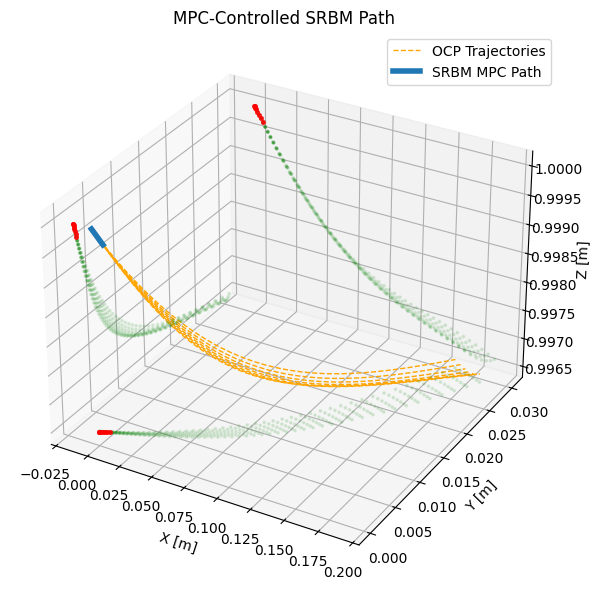

In [4]:
ocp_pos = x_traj[:, :, :3] 
sim_pos = x_sim[:, :3] if sim_solver else x_traj[:, 0, :3] 
plot_mpc_path(sim_pos, ocp_pos, project=True)